<a href="https://colab.research.google.com/github/oytungunes/PythonCodeExamples/blob/main/MosaicDataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mosaic Augmentation örnek kod

https://github.com/jason9075/opencv-mosaic-data-aug



In [1]:
# drive ı yukle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import random
import cv2
import os
import glob
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow


OUTPUT_SIZE = (600, 600)  # Height, Width
SCALE_RANGE = (0.3, 0.7)
FILTER_TINY_SCALE = 1 / 50  # if height or width lower than this scale, drop it.

ANNO_DIR = '/content/drive/MyDrive/Annotations/'
IMG_DIR = '/content/drive/MyDrive/Images/'

category_name = ['background', 'person']


def main():
    img_paths, annos = get_dataset(ANNO_DIR, IMG_DIR)

    idxs = random.sample(range(len(annos)), 4)

    new_image, new_annos = update_image_and_anno(img_paths, annos,
                                                 idxs,
                                                 OUTPUT_SIZE, SCALE_RANGE,
                                                 filter_scale=FILTER_TINY_SCALE)
    cv2_imshow(new_image);

  #  cv2.imwrite('/content/drive/MyDrive/mosaicimg/output.jpg', new_image)
    for anno in new_annos:
        start_point = (int(anno[1] * OUTPUT_SIZE[1]), int(anno[2] * OUTPUT_SIZE[0]))
        end_point = (int(anno[3] * OUTPUT_SIZE[1]), int(anno[4] * OUTPUT_SIZE[0]))
        cv2.rectangle(new_image, start_point, end_point, (0, 255, 0), 1, cv2.LINE_AA)
   # cv2.imwrite('/content/drive/MyDrive/mosaicimg/output_box.jpg', new_image)

    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = Image.fromarray(new_image.astype(np.uint8))
    new_image.show()


def update_image_and_anno(all_img_list, all_annos, idxs, output_size, scale_range, filter_scale=0.):
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    divid_point_x = int(scale_x * output_size[1])
    divid_point_y = int(scale_y * output_size[0])

    new_anno = []
    for i, idx in enumerate(idxs):
        path = all_img_list[idx]
        img_annos = all_annos[idx]

        img = cv2.imread(path)
        if i == 0:  # top-left
            img = cv2.resize(img, (divid_point_x, divid_point_y))
            output_img[:divid_point_y, :divid_point_x, :] = img
            for bbox in img_annos:
                xmin = bbox[1] * scale_x
                ymin = bbox[2] * scale_y
                xmax = bbox[3] * scale_x
                ymax = bbox[4] * scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

        elif i == 1:  # top-right
            img = cv2.resize(img, (output_size[1] - divid_point_x, divid_point_y))
            output_img[:divid_point_y, divid_point_x:output_size[1], :] = img
            for bbox in img_annos:
                xmin = scale_x + bbox[1] * (1 - scale_x)
                ymin = bbox[2] * scale_y
                xmax = scale_x + bbox[3] * (1 - scale_x)
                ymax = bbox[4] * scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        elif i == 2:  # bottom-left
            img = cv2.resize(img, (divid_point_x, output_size[0] - divid_point_y))
            output_img[divid_point_y:output_size[0], :divid_point_x, :] = img
            for bbox in img_annos:
                xmin = bbox[1] * scale_x
                ymin = scale_y + bbox[2] * (1 - scale_y)
                xmax = bbox[3] * scale_x
                ymax = scale_y + bbox[4] * (1 - scale_y)
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        else:  # bottom-right
            img = cv2.resize(img, (output_size[1] - divid_point_x, output_size[0] - divid_point_y))
            output_img[divid_point_y:output_size[0], divid_point_x:output_size[1], :] = img
            for bbox in img_annos:
                xmin = scale_x + bbox[1] * (1 - scale_x)
                ymin = scale_y + bbox[2] * (1 - scale_y)
                xmax = scale_x + bbox[3] * (1 - scale_x)
                ymax = scale_y + bbox[4] * (1 - scale_y)
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

    if 0 < filter_scale:
        new_anno = [anno for anno in new_anno if
                    filter_scale < (anno[3] - anno[1]) and filter_scale < (anno[4] - anno[2])]

    return output_img, new_anno


def get_dataset(anno_dir, img_dir):
    class_id = category_name.index('person')

    img_paths = []
    annos = []
    for anno_file in glob.glob(os.path.join(anno_dir, '*.txt')):
        anno_id = anno_file.split('/')[-1].split('.')[0]

        with open(anno_file, 'r') as f:
            num_of_objs = int(f.readline())

            img_path = os.path.join(img_dir, f'{anno_id}.jpg')
            img = cv2.imread(img_path)
            img_height, img_width, _ = img.shape
            del img

            boxes = []
            for _ in range(num_of_objs):
                obj = f.readline().rstrip().split(' ')
                obj = [int(elm) for elm in obj]
                if 3 < obj[0]:
                    continue

                xmin = max(obj[1], 0) / img_width
                ymin = max(obj[2], 0) / img_height
                xmax = min(obj[3], img_width) / img_width
                ymax = min(obj[4], img_height) / img_height

                boxes.append([class_id, xmin, ymin, xmax, ymax])

            if not boxes:
                continue

        img_paths.append(img_path)
        annos.append(boxes)
    return img_paths, annos


#if __name__ == '__main__':


### Burada Mosaic Augmentation Yapılmış main çalıştırılınca goruluyor, annotationstan kurtarmak gerekebilir kodu

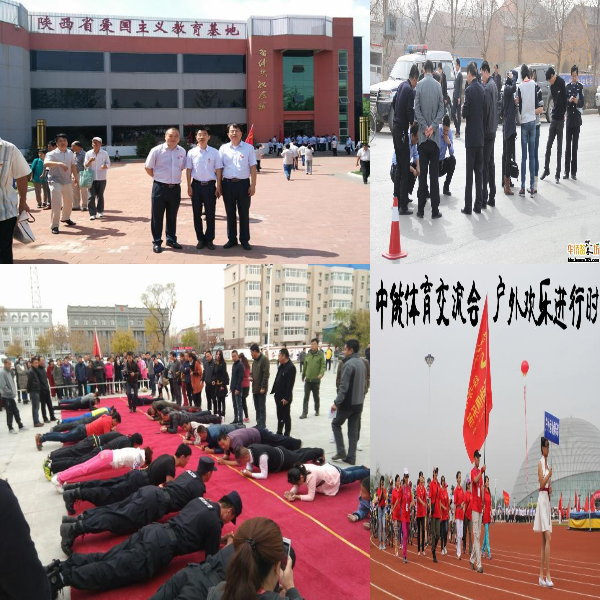

In [22]:
main()

